
# AI Essentials - Predict Final Math Grade


**Student:** -- firstname lastname --  
**Title:** Using Student Information to Predict Final Math Grade  
**Notebook deadline:** 25/08/2025  
**Video deadline:** 29/08/2025


## Problem definition
Goal: predict **final math grade (G3)** from student information in `student-mat.csv`.  
Type: **regression** (continuous target).  
Plan: EDA → preprocessing → train & tune at least 3 models → compare → discuss over/underfitting → save best model for an API.


## Setup and Helpers



In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)

def eval_reg(y_true, y_pred):
    """Return common regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    return {
        "RMSE": float(np.sqrt(mse)),
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "R2":   float(r2_score(y_true, y_pred)),
    }

print("✔️ Setup complete")


✔️ Setup complete


### Load data


In [2]:
# Make sure the CSV sits next to the notebook
df = pd.read_csv("student-mat.csv", sep=";")
df.shape


(395, 33)

### Quick EDA.

In [3]:
display(df.head())
display(df.describe(include='all').T)
df.isna().sum().sort_values(ascending=False).head(10)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395.0,NaN,NaN,NaN,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
address,395,2,U,307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,395,2,GT3,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,395,2,T,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,395.0,NaN,NaN,NaN,2.749367,1.094735,0.0,2.0,3.0,4.0,4.0
Fedu,395.0,NaN,NaN,NaN,2.521519,1.088201,0.0,2.0,2.0,3.0,4.0
Mjob,395,5,other,141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,395,5,other,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN


school      0
paid        0
G2          0
G1          0
absences    0
health      0
Walc        0
Dalc        0
goout       0
freetime    0
dtype: int64

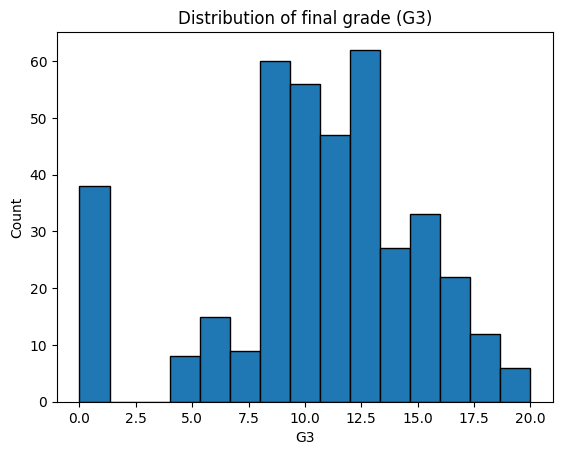

In [4]:
plt.figure()
plt.hist(df["G3"], bins=15, edgecolor="k")
plt.title("Distribution of final grade (G3)")
plt.xlabel("G3"); plt.ylabel("Count")
plt.show()


### Target, feature sets, split

In [5]:
TARGET = "G3"
X = df.drop(columns=[TARGET])
y = df[TARGET]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Numerical:", len(num_cols), "| Categorical:", len(cat_cols))
X_train.shape, X_test.shape


Numerical: 15 | Categorical: 17


((316, 32), (79, 32))

### Preprocessing

In [6]:
# Numerical: median impute + scale
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Categorical: most-frequent impute + One-Hot
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
])
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'Medu', 'Fedu', 'traveltime',
                                  'studytime', 'failures', 'famrel', 'freetime',
                                  'goout', 'Dalc', 'Walc', 'health', 'absences',
                                  'G1', 'G2']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['school', 'sex', 'address', 'famsize',
                                  'Pstatus', 'Mjob', 'Fjob', 'reason',
                                  'guardian', 'schoolsup', 'famsup', 'paid',
                                  'activities', 'nursery', 'higher', 'internet',
                                  'romantic'])])

### Baseline

In [7]:
baseline = Pipeline([
    ("prep", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
]).fit(X_train, y_train)

baseline_metrics = eval_reg(y_test, baseline.predict(X_test))
baseline_metrics


{'RMSE': 4.550180652162387,
 'MAE': 3.64585002403461,
 'R2': -0.009709643515769084}

### Why these models
- **Ridge (linear)** — simple, regularized baseline for numeric + one-hot data.  
- **Decision Tree** — easy to explain; shows overfitting behavior clearly.  
- **Random Forest** — ensemble of trees; usually generalizes better.

### Model 1 - Ridge

In [8]:
ridge = Pipeline([
    ("prep", preprocessor),
    ("model", Ridge())
])
param_ridge = {"model__alpha": np.logspace(-2, 2, 9)}

ridge_cv = GridSearchCV(
    ridge, param_ridge, scoring="neg_mean_squared_error", cv=3, n_jobs=1, refit=True
)
ridge_cv.fit(X_train, y_train)

ridge_best = ridge_cv.best_estimator_
ridge_cv_rmse = float(np.sqrt(-ridge_cv.best_score_))
ridge_metrics = eval_reg(y_test, ridge_best.predict(X_test))

print("Best Ridge:", ridge_cv.best_params_, "| CV-RMSE:", ridge_cv_rmse)
ridge_metrics


Best Ridge: {'model__alpha': 10.0} | CV-RMSE: 1.9468327206873401


{'RMSE': 2.3277456941767443,
 'MAE': 1.589310594364736,
 'R2': 0.7357528638718704}

### Model 2 - Decision Tree

In [9]:
dt = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
])
param_dt = {
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

dt_cv = GridSearchCV(
    dt, param_dt, scoring="neg_mean_squared_error", cv=3, n_jobs=1, refit=True
)
dt_cv.fit(X_train, y_train)

dt_best = dt_cv.best_estimator_
dt_cv_rmse = float(np.sqrt(-dt_cv.best_score_))
dt_metrics = eval_reg(y_test, dt_best.predict(X_test))

print("Best DT:", dt_cv.best_params_, "| CV-RMSE:", dt_cv_rmse)
dt_metrics


Best DT: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5} | CV-RMSE: 1.8519571247003148


{'RMSE': 2.3989904961670154,
 'MAE': 1.3348686566903405,
 'R2': 0.7193298154614558}

### Model 3 - Random Forest


In [10]:
rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1))
])
param_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", 0.8],
    "model__bootstrap": [True],
}

rf_cv = GridSearchCV(
    rf, param_rf, scoring="neg_mean_squared_error", cv=3, n_jobs=1, refit=True
)
rf_cv.fit(X_train, y_train)

rf_best = rf_cv.best_estimator_
rf_cv_rmse = float(np.sqrt(-rf_cv.best_score_))
rf_metrics = eval_reg(y_test, rf_best.predict(X_test))

print("Best RF:", rf_cv.best_params_, "| CV-RMSE:", rf_cv_rmse)
rf_metrics


Best RF: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 0.8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 400} | CV-RMSE: 1.5745844135996336


{'RMSE': 1.9651354453044918,
 'MAE': 1.1805709011452674,
 'R2': 0.8116679631162677}

### Compare Results

In [11]:
results = pd.DataFrame([
    {"Model":"Baseline(mean)", **baseline_metrics},
    {"Model":"Ridge(best)", **ridge_metrics, "CV_RMSE": ridge_cv_rmse, "Params": ridge_cv.best_params_},
    {"Model":"DecisionTree(best)", **dt_metrics, "CV_RMSE": dt_cv_rmse, "Params": dt_cv.best_params_},
    {"Model":"RandomForest(best)", **rf_metrics, "CV_RMSE": rf_cv_rmse, "Params": rf_cv.best_params_},
]).sort_values("RMSE").reset_index(drop=True)

display(results[["Model","RMSE","MAE","R2","CV_RMSE","Params"]])


,Model,RMSE,MAE,R2,CV_RMSE,Params
0,RandomForest(best),1.965135,1.180571,0.811668,1.574584,"{'model__bootstrap': True, 'model__max_depth':..."
1,Ridge(best),2.327746,1.589311,0.735753,1.946833,{'model__alpha': 10.0}
2,DecisionTree(best),2.398990,1.334869,0.719330,1.851957,"{'model__max_depth': 5, 'model__min_samples_le..."
3,Baseline(mean),4.550181,3.645850,-0.009710,NaN,NaN


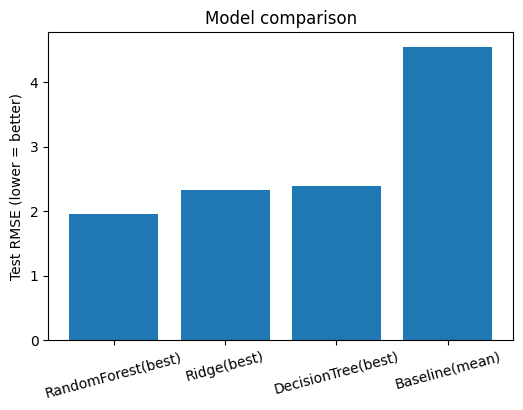

In [12]:
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["RMSE"])
plt.ylabel("Test RMSE (lower = better)")
plt.xticks(rotation=15)
plt.title("Model comparison")
plt.show()


### Learning curves (over/underfitting check)

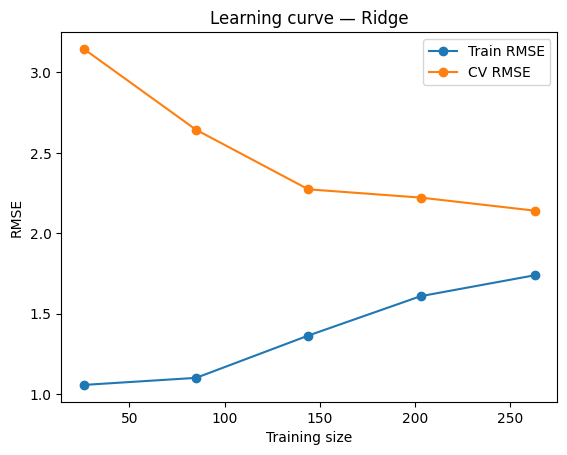

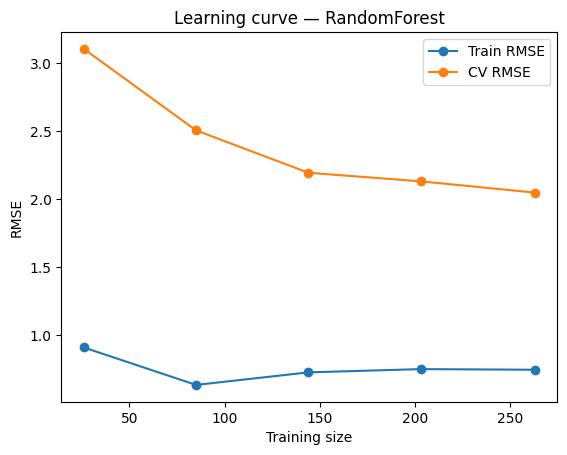

In [13]:
def plot_learning_curve(model, X, y, title):
    sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=1
    )
    train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
    test_rmse  = np.sqrt(-np.mean(test_scores,  axis=1))
    plt.figure()
    plt.plot(sizes, train_rmse, marker='o', label='Train RMSE')
    plt.plot(sizes, test_rmse,  marker='o', label='CV RMSE')
    plt.xlabel("Training size"); plt.ylabel("RMSE")
    plt.title(title); plt.legend(); plt.show()

plot_learning_curve(ridge_best, X, y, "Learning curve — Ridge")
plot_learning_curve(rf_best,    X, y, "Learning curve — RandomForest")


### Short conclusion
- **Decision Tree**: simple but overfits easily (train better than test).  
- **Ridge**: stable and low variance, but limited for non-linear effects.  
- **Random Forest**: best overall (lowest RMSE, highest R²).  
Conclusion: **use Random Forest** for this task.

### Save best pipeline for the API

In [14]:
import joblib

# Pick best by lowest RMSE
best_row = results.iloc[0]["Model"]
pick = {
    "Ridge(best)": ridge_best,
    "DecisionTree(best)": dt_best,
    "RandomForest(best)": rf_best
}
best_pipeline = pick.get(best_row, rf_best)  # default to RF

joblib.dump(best_pipeline, "best_model.joblib")           # full sklearn Pipeline
joblib.dump(list(X.columns), "feature_names.joblib")      # raw column names (optional)
print("✔️ Saved: best_model.joblib (full pipeline), feature_names.joblib")


✔️ Saved: best_model.joblib (full pipeline), feature_names.joblib
